In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib.ticker import FuncFormatter
import random as ra
from scipy.optimize import curve_fit
from scipy.integrate import odeint
import math

This is the code for Figure 2 in the main text. All datafiles are in a folder named "Data".  

Datafiles details are below:

MYb71 CD - datafile with bacterial loads for the species MYb71 at different colonization densities    
MYb120 CD - datafile with bacterial loads for the species MYb120   at different colonization densities   

In [2]:
def MYB71_plotfun():
    
    # Load and preprocess the data
    
    MYb71CD = pd.read_csv("../Data/MYb71 CD.csv")


    Ndata_raw = MYb71CD["CFU"].to_numpy()
    tdata_raw = MYb71CD["Time"].to_numpy()

    newvar = np.log10(np.maximum(1,Ndata_raw).reshape(3,4,24))
    
    # Calculate experimental statistics

    exp_stats = np.zeros((3,4,4))


    for j in range(len(np.unique(MYb71CD["Density"]))):
        for i in range(len(np.unique(tdata_raw))):
            exp_stats[j,i,0] = np.nanmean(newvar[j,i,:])
            exp_stats[j,i,1] = np.nanstd(newvar[j,i,:])
            exp_stats[j,i,2] = np.sum(newvar[j,i,:] > 0)
            exp_stats[j,i,3] = np.sum(newvar[j,i,:] == 0)

    # Define constants and initialize arrays for simulation

    c_values = [0.1, 1, 10]

    repnum = 10
    expnum = 24
    tottime = 40
    tstep = 1/4
    tpnum = int(tottime/tstep)

    newtime = np.arange(0,tottime, tstep)

    gil = np.zeros((repnum, len(c_values),expnum,tpnum))
    
    #old parameters from "WormMatters_Fig1.ipynb"

    old_V=  17576.802330846043 
    old_c=  0.07482364412768554 
    b=  1.226909226831348 
    d=  0.579882811873879
    
# Gillespie simulations for the stochastic model with fit parameters and varying c (colonization) and V (carrying capacity)
      
    for rep in range(repnum):
        for i in range(len(c_values)):
            c_value = c_values[i]
            c = c_value*old_c

            for expt in range(expnum):

                #V = ra.gauss(old_V, 100) 
                #V = old_V
                V = 10**(np.random.choice(newvar[2,3,:]))

                t = 0.0
                N = 0.0


                step = 0

                while t < tottime:

                    if t >= step*tstep:
                        while step*tstep <= t:
                            gil[rep,i, expt,step] = N
                            step = step + 1

                    E = V - N
                    a1 = c*(E/V)
                    a2 = b*E*(N/V)
                    a3 = d*N
                    a = a1 + a2 + a3
                    r1 = ra.uniform(0,1)
                    r2 = ra.uniform(0,1)
                    tau = 1/a*math.log(1/r1)
                    t = t + tau
                    targeta = a*r2
                    if targeta < a1:
                        N = N + 1
                    elif targeta < a1 + a2:
                        N = N + 1
                    else:
                        N = N -1      

                    if N <= 0:
                        break 
                    
    newgil = np.log10(np.maximum(1,gil))
    
    # Calculate simulation statistics

    sim_stats = np.zeros((10,3,4,4))

    for m in range(10):
        for j in range(3):
            for i, t in enumerate([48,72,96,144]):
                sim_stats[m,j,i,0] = np.nanmean(newgil[m,j,:,t])
                sim_stats[m,j,i,1] = np.nanstd(newgil[m,j,:,t])
                sim_stats[m,j,i,2] = np.sum(newgil[m,j,:,t] > 0)
                sim_stats[m,j,i,3] = np.sum(newgil[m,j,:,t] == 0)


    sim_stats_new = np.zeros((3,4,4))

    for j in range(3):
        for i, t in enumerate([48,72,96,144]):
            sim_stats_new[j,i,0] = np.nanmean(sim_stats[:,j,i,2]) #nonzeromeans
            sim_stats_new[j,i,1] = np.nanstd(sim_stats[:,j,i,2]) #nonzerostds
            sim_stats_new[j,i,2]= np.nanmean(sim_stats[:,j,i,3]) #zeromeans
            sim_stats_new[j,i,3] = np.nanstd(sim_stats[:,j,i,3]) #zerostds
            
            
    # Solve deterministic model

    def meanfieldeq(Ndet,tdet):
        return old_c*(1-(Ndet/old_V)) + b*(Ndet)*(1-(Ndet/old_V)) - d* (Ndet)

    tdet = np.linspace(0,40,800)
    N0 = 1
    detsol = np.log10(odeint(meanfieldeq,N0,tdet))

    # Plot results against the data

    palette = ['deeppink', 'magenta', 'purple']


    for j in range(len(np.unique(MYb71CD["Density"]))):
        ax = plt.subplot(2,3,j+1)
        color = palette[j]
        for i in range(len(np.unique(tdata_raw))):

            violin = plt.violinplot(newvar[j,i,:][~np.isnan(newvar[j,i,:])], positions = np.array([np.unique(tdata_raw)[i]]),
                       bw_method =0.3,showextrema = False, showmeans = False, widths=4)


            for part in violin['bodies']:
                part.set_facecolor(color)

            plt.scatter(tdata_raw.reshape(3,4,24)[j,i]+ np.random.uniform(-1.4, 1.4, size=24), newvar[j,i,:], 
                        s=50,  alpha =0.6, color = color)
            plt.plot(tdata_raw.reshape(3,4,24)[j,i][0], np.nanmean(newvar[j,i,:]),'p' ,markersize = 11, color = 'navy')



        plt.plot(newtime, newgil[0,j,0,:], '',  color = 'cornflowerblue', linewidth = 1.5, label = 'stochastic')
        plt.plot(newtime, np.transpose(newgil[0,j,1:,:]), '',  color = 'cornflowerblue', linewidth = 1.5)
        plt.plot(tdet,detsol, '--', label = 'deterministic', linewidth = 2, color = 'black')
        
        plt.legend([f'MYb71, 10^{j+7} CFU/ml'], loc='upper left', fontsize='14')
        ax.yaxis.set_major_formatter(FuncFormatter(lambda x, _: f'$10^{{{int(x)}}}$'))

        
        ax.set_ylim(-3,6)
        ax.set_yticks(np.arange(0, 6, 1))       


        ax.tick_params(axis='y', labelsize=17)
        ax.tick_params(axis='x', labelsize=17)
        if j == 0:  
            ax.set_ylabel("CFU/worm", fontsize=24)
                   
        
        
        ax2 = ax.twinx()
        width = 1.00 
        x_exp = np.unique(tdata_raw) - width
        x_sim = np.unique(tdata_raw) + width

        
        ax2.bar(x_exp, exp_stats[j,:,3]*100/24, color='navy', alpha=0.5, width=width, align='center', label='Zero Occupancy (Exp)')
        ax2.bar(x_sim, sim_stats[0,j,:,3]*100/24, color='cornflowerblue', alpha=0.5, width=width, align='center', label='Zero Occupancy (Sim)')
        ax2.errorbar(x_sim, sim_stats_new[j,:,2]*100/24, yerr = sim_stats_new[j,:,3]*100/24, ls = '')
        ax2.errorbar(x_exp, exp_stats[j,:,3]*100/24, yerr = np.sqrt((exp_stats[j,:,3])*(1-(exp_stats[j,:,3]/24.0)))*100/24, ls = '')

        ax2.set_ylim(0,350)
        ax2.set_yticks(np.arange(0, 105, 25))
        ax2.tick_params(axis='y', labelsize=17)
        if j == 2:
            ax2.set_ylabel("Zero Occupancy", fontsize=20)


        #ax.set_xlabel("Time (hrs)", fontsize = 22)

        plt.xlim(0,40)
    

def MYB120_plotfun():

    # Load and preprocess the data
    
    MYb120CD = pd.read_csv("../Data/MYb120 CD.csv")


    Ndata_raw = MYb120CD["CFU"].to_numpy()
    tdata_raw = MYb120CD["Time"].to_numpy()

    newvar = np.log10(np.maximum(1,Ndata_raw).reshape(3,4,24))
    
    # Calculate experimental statistics
    
    exp_stats = np.zeros((3,4,4))


    for j in range(len(np.unique(MYb120CD["Density"]))):
        for i in range(len(np.unique(tdata_raw))):
            exp_stats[j,i,0] = np.nanmean(newvar[j,i,:])
            exp_stats[j,i,1] = np.nanstd(newvar[j,i,:])
            exp_stats[j,i,2] = np.sum(newvar[j,i,:] > 0)
            exp_stats[j,i,3] = np.sum(newvar[j,i,:] == 0)

    # Define constants and initialize arrays for simulation
    
    c_values = [0.1, 1, 10]
    

    
    repnum = 10
    expnum = 24
    tottime = 40
    tstep = 1/4
    tpnum = int(tottime/tstep)

    newtime = np.arange(0,tottime, tstep)

    gil = np.zeros((repnum, len(c_values),expnum,tpnum))

    #old parameters from "WormMatters_Fig1.ipynb"
    
    old_V=  147.10218370610394 
    old_c=  0.08534320703527948 
    b=  2.5796950519441504 
    d=  1.403963192627953
    
    
# Gillespie simulations for the stochastic model with fit parameters and varying c (colonization) and V (carrying capacity)
    
    for rep in range(repnum):
        for i in range(len(c_values)):
        
            c_value = c_values[i]
            c = c_value*old_c

            for expt in range(expnum):


                V = 10**(np.random.choice(newvar[2,3,:]))

                t = 0.0
                N = 0.0


                step = 0

                while t < tottime:

                    if t >= step*tstep:
                        while step*tstep <= t:
                            gil[rep,i, expt,step] = N
                            step = step + 1

                    E = V - N
                    a1 = c*(E/V)
                    a2 = b*E*(N/V)
                    a3 = d*N
                    a = a1 + a2 + a3
                    r1 = ra.uniform(0,1)
                    r2 = ra.uniform(0,1)
                    tau = 1/a*math.log(1/r1)
                    t = t + tau
                    targeta = a*r2
                    if targeta < a1:
                        N = N + 1
                    elif targeta < a1 + a2:
                        N = N + 1 
                    else:
                        N = N -1      

                    if N <= 0:
                        break 

    newgil = np.log10(np.maximum(1,gil))

    # Calculate simulation statistics
    
    sim_stats = np.zeros((10,3,4,4))

    for m in range(10):
        for j in range(3):
            for i, t in enumerate([48,72,96,144]):
                sim_stats[m,j,i,0] = np.nanmean(newgil[m,j,:,t])
                sim_stats[m,j,i,1] = np.nanstd(newgil[m,j,:,t])
                sim_stats[m,j,i,2] = np.sum(newgil[m,j,:,t] > 0)
                sim_stats[m,j,i,3] = np.sum(newgil[m,j,:,t] == 0)


    sim_stats_new = np.zeros((3,4,4))

    for j in range(3):
        for i, t in enumerate([48,72,96,144]):
            sim_stats_new[j,i,0] = np.nanmean(sim_stats[:,j,i,2]) #nonzeromeans
            sim_stats_new[j,i,1] = np.nanstd(sim_stats[:,j,i,2]) #nonzerostds
            sim_stats_new[j,i,2]= np.nanmean(sim_stats[:,j,i,3]) #zeromeans
            sim_stats_new[j,i,3] = np.nanstd(sim_stats[:,j,i,3]) #zerostds

    
    # Solve deterministic model
            
    def meanfieldeq(Ndet,tdet):
        return old_c*(1-(Ndet/old_V)) + b*(Ndet)*(1-(Ndet/old_V)) - d* (Ndet)

    tdet = np.linspace(0,40,800)
    N0 = 1
    detsol = np.log10(odeint(meanfieldeq,N0,tdet))


    
    # Plot results against the data
    palette = ['salmon', 'orangered', 'red']


    
    for j in range(len(np.unique(MYb120CD["Density"]))):
        ax = plt.subplot(2,3,j+4)
        color = palette[j]
        for i in range(len(np.unique(tdata_raw))):

            violin = plt.violinplot(newvar[j,i,:][~np.isnan(newvar[j,i,:])], positions = np.array([np.unique(tdata_raw)[i]]),
                       bw_method =0.3,showextrema = False, showmeans = False, widths=4)


            for part in violin['bodies']:
                part.set_facecolor(color)

            plt.scatter(tdata_raw.reshape(3,4,24)[j,i]+ np.random.uniform(-1.4, 1.4, size=24), newvar[j,i,:], 
                        s=50,  alpha =0.6, color = color)
            plt.plot(tdata_raw.reshape(3,4,24)[j,i][0], np.nanmean(newvar[j,i,:]),'p' ,markersize = 11, color = 'navy')


        ax.plot(newtime, newgil[0,j,0,:], '',  color = 'cornflowerblue', linewidth = 1.5, label = 'stochastic')
        ax.plot(newtime, np.transpose(newgil[0,j,1:,:]), '',  color = 'cornflowerblue', linewidth = 1.5)
        ax.plot(tdet,detsol, '--', label = 'deterministic', linewidth = 2, color = 'black')
        
        ax.legend([f' MYb120, 10^{j+7} CFU/ml'], loc='upper left', fontsize='14')
        ax.yaxis.set_major_formatter(FuncFormatter(lambda x, _: f'$10^{{{int(x)}}}$'))

        
        ax.set_ylim(-3,6)
        ax.set_yticks(np.arange(0, 6, 1))       


        ax.tick_params(axis='y', labelsize=17)
        ax.tick_params(axis='x', labelsize=17)
        if j == 0:  
            ax.set_ylabel("CFU/worm", fontsize=24)        
        
        
        ax2 = ax.twinx()
        width = 1.00 
        x_exp = np.unique(tdata_raw) - width
        x_sim = np.unique(tdata_raw) + width
        
        ax2.bar(x_exp, exp_stats[j,:,3]*100.0/24.0, color='navy', alpha=0.5, width=width, align='center', label='Zero Occupancy (Exp)')
        ax2.bar(x_sim, sim_stats[0,j,:,3]*100.0/24.0, color='cornflowerblue', alpha=0.5, width=width, align='center', label='Zero Occupancy (Sim)')
        ax2.errorbar(x_sim, sim_stats_new[j,:,2]*100/24, yerr = sim_stats_new[j,:,3]*100/24, ls = '')
        ax2.errorbar(x_exp, exp_stats[j,:,3]*100/24, yerr = np.sqrt((exp_stats[j,:,3])*(1-(exp_stats[j,:,3]/24.0)))*100/24, ls = '')


        ax2.set_ylim(0,350)
        ax2.set_yticks(np.arange(0, 105, 25))
        ax2.tick_params(axis='y', labelsize=17)
        if j == 2:
            ax2.set_ylabel("Zero Occupancy", fontsize=20)


        ax.set_xlabel("Time (hrs)", fontsize = 22)

        plt.xlim(0,40)

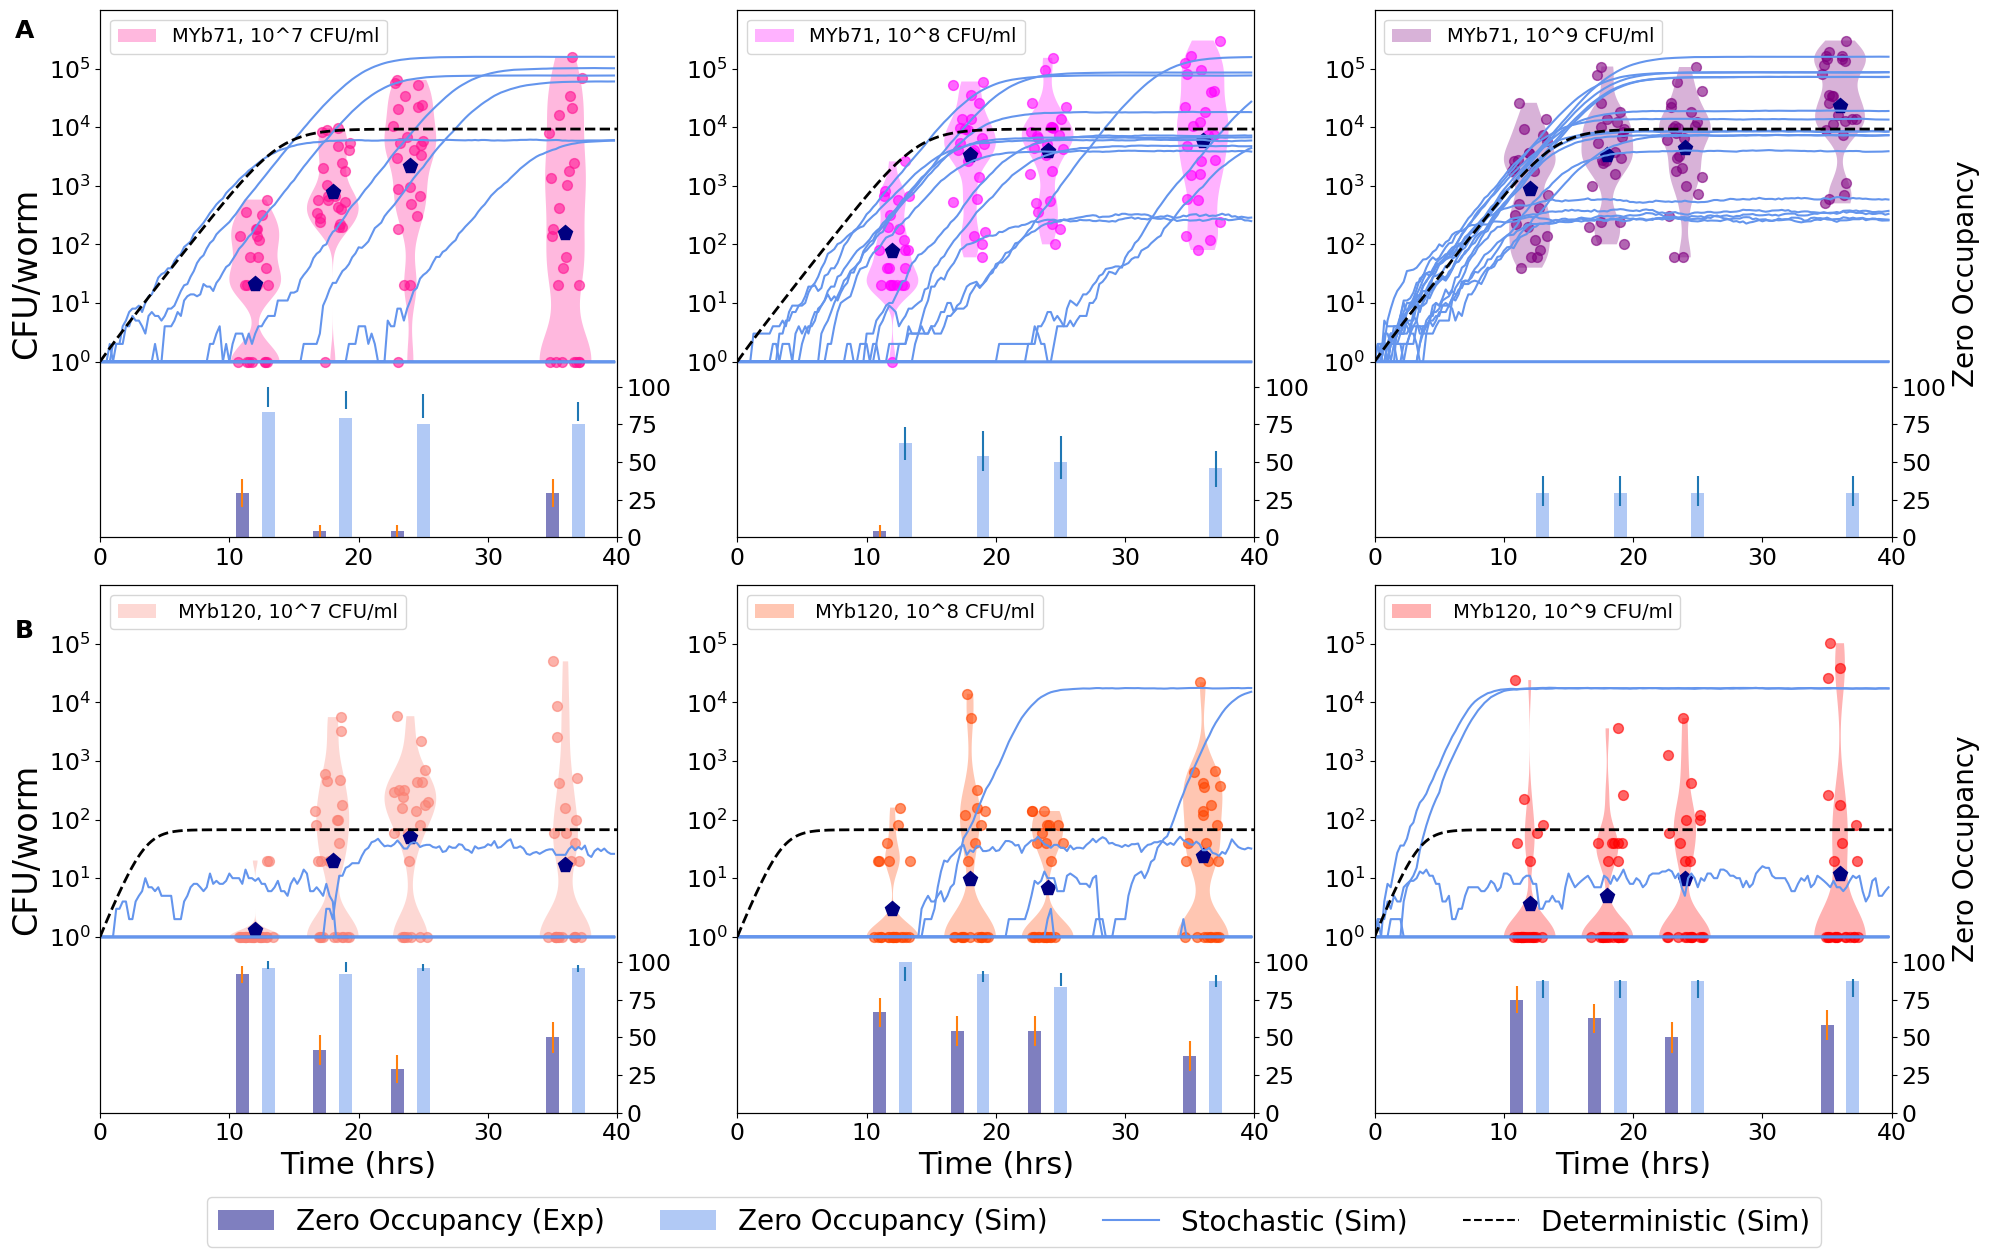

In [3]:
fig = plt.figure(figsize=(20, 12))


MYB71_plotfun()

MYB120_plotfun()


handles, labels = plt.gcf().get_axes()[-1].get_legend_handles_labels()

stochastic_handle = plt.Line2D([0], [0], color='cornflowerblue', linestyle='-')
deterministic_handle = plt.Line2D([0], [0], color='black', linestyle='--')


handles.extend([stochastic_handle, deterministic_handle])
labels.extend(['Stochastic (Sim)', 'Deterministic (Sim)'])

plt.figlegend(handles, labels, loc='upper right', ncol = 4, fontsize='20', bbox_to_anchor=(0.92, 0.01))

fig.text(0.01, 0.98, "A", fontsize=18, va='top', ha='left',weight='bold')
fig.text(0.01, 0.48, "B", fontsize=18, va='top', ha='left',weight='bold')

plt.tight_layout(w_pad=1.0)

plt.savefig("../Figures/CDfigure_sims.pdf", dpi = 300, bbox_inches='tight')
plt.show()

